In [1]:
# If any of these are missing in your venv, install them here.
%pip install pandas numpy matplotlib seaborn statsmodels pytrends duckdb xlsxwriter

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Core imports and style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

sns.set_context("talk")
sns.set_style("whitegrid")

# Create local folders if they don't exist
Path("../data").mkdir(parents=True, exist_ok=True)
Path("../assets").mkdir(parents=True, exist_ok=True)
Path("../reports").mkdir(parents=True, exist_ok=True)


In [3]:
# Parameters for signal ingestion
GEO = "US"            # change to "MX" to pull Mexico; "US" is a common benchmark
TIMEFRAME = "today 5-y"   # 5 years of weekly data
KW_LIST = ["sneakers", "laptops", "furniture", "cosmetics", "groceries"]  # retail-ish topics/keywords

print({"geo": GEO, "timeframe": TIMEFRAME, "keywords": KW_LIST})

{'geo': 'US', 'timeframe': 'today 5-y', 'keywords': ['sneakers', 'laptops', 'furniture', 'cosmetics', 'groceries']}


In [4]:
# Fetch weekly Google Trends interest_over_time for the configured keywords
from pytrends.request import TrendReq
import time

def fetch_trends(kw_list, geo="US", timeframe="today 5-y", sleep=1.5):
    """Return a tidy DataFrame with date, keyword, value from Google Trends."""
    pytrends = TrendReq(hl="en-US", tz=360)
    all_frames = []
    # Pull in batches of <=5 (pytrends limit)
    for i in range(0, len(kw_list), 5):
        batch = kw_list[i:i+5]
        pytrends.build_payload(batch, cat=0, timeframe=timeframe, geo=geo, gprop="")
        df = pytrends.interest_over_time()
        if df.empty:
            continue
        if "isPartial" in df.columns:
            df = df.drop(columns=["isPartial"])
        df = df.reset_index().melt(id_vars="date", var_name="keyword", value_name="trend")
        all_frames.append(df)
        time.sleep(sleep)
    if not all_frames:
        return pd.DataFrame(columns=["date","keyword","trend"])
    out = pd.concat(all_frames, ignore_index=True)
    out = out.sort_values(["keyword","date"]).reset_index(drop=True)
    return out

trends_raw = fetch_trends(KW_LIST, geo=GEO, timeframe=TIMEFRAME)
trends_raw.head()


/Users/danyzamora/Documents/Retail-Trend-Activation-Radar/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/danyzamora/Documents/Retail-Trend-Activation-Radar/.venv/lib/python3.9/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,date,keyword,trend
0,2020-08-09,cosmetics,6
1,2020-08-16,cosmetics,6
2,2020-08-23,cosmetics,6
3,2020-08-30,cosmetics,6
4,2020-09-06,cosmetics,6


In [5]:
# Feature engineering: moving average, YoY index, rolling z-score
def add_signal_features(df, w_ma=4, w_z=12, yoy_lag=52):
    """Add smoothed trend, YoY index, and rolling z-score per keyword."""
    df = df.copy()
    df["trend"] = pd.to_numeric(df["trend"], errors="coerce").fillna(0)
    out = []
    for kw, g in df.groupby("keyword", group_keys=False):
        g = g.sort_values("date")
        g["trend_ma"] = g["trend"].rolling(w_ma, min_periods=max(1, w_ma//2)).mean()
        g["yoy_idx"] = (g["trend"] / g["trend"].shift(yoy_lag) * 100.0).replace([np.inf, -np.inf], np.nan)
        # rolling z-score on smoothed trend
        m = g["trend_ma"].rolling(w_z, min_periods=max(3, w_z//3)).mean()
        s = g["trend_ma"].rolling(w_z, min_periods=max(3, w_z//3)).std(ddof=0)
        g["z_score"] = (g["trend_ma"] - m) / s
        out.append(g)
    return pd.concat(out, ignore_index=True)

trends = add_signal_features(trends_raw)
trends.tail()


,date,keyword,trend,trend_ma,yoy_idx,z_score
1305,2025-07-13,sneakers,20,17.25,111.111111,-0.907265
1306,2025-07-20,sneakers,21,18.50,116.666667,0.742307
1307,2025-07-27,sneakers,24,20.50,133.333333,2.363904
1308,2025-08-03,sneakers,22,21.75,110.000000,2.377061
1309,2025-08-10,sneakers,21,22.00,105.000000,1.917193


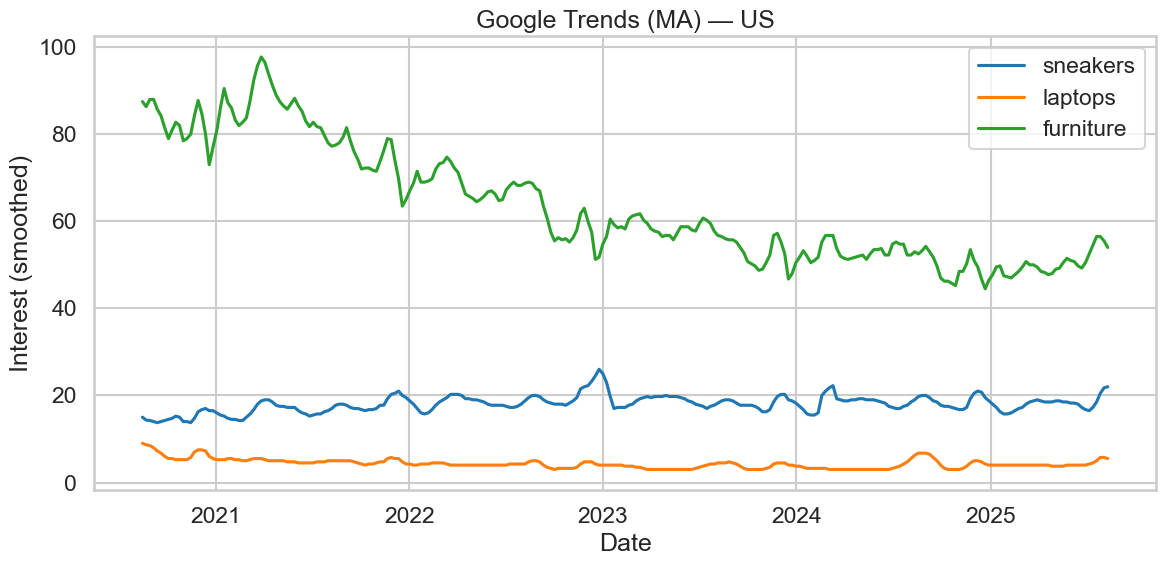

In [6]:
# Quick visual for the first 3 keywords
plt.figure(figsize=(12,6))
for kw in KW_LIST[:3]:
    g = trends.loc[trends["keyword"]==kw]
    plt.plot(g["date"], g["trend_ma"], label=kw)
plt.title(f"Google Trends (MA) — {GEO}")
plt.xlabel("Date")
plt.ylabel("Interest (smoothed)")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# Define "hot windows" where both YoY > 110 and z_score > 1.2
crit_yoy = 110.0
crit_z   = 1.2

hot = trends[(trends["yoy_idx"] >= crit_yoy) & (trends["z_score"] >= crit_z)].copy()
hot["month"] = hot["date"].dt.to_period("M").astype(str)

# Aggregate by keyword x month
hot_windows = (hot.groupby(["keyword","month"], as_index=False)
                 .agg(avg_yoy=("yoy_idx","mean"),
                      avg_z=("z_score","mean"),
                      days=("date","count"))
                 .sort_values(["keyword","month"]))

hot_windows.head(10)


,keyword,month,avg_yoy,avg_z,days
0,cosmetics,2021-08,200.000000,1.499634,1
1,cosmetics,2021-11,175.000000,1.993270,1
2,cosmetics,2021-12,150.000000,1.659308,1
3,cosmetics,2022-06,150.000000,1.854097,2
4,cosmetics,2025-06,120.000000,1.920944,1
5,cosmetics,2025-07,150.000000,2.489474,2
6,cosmetics,2025-08,125.000000,2.068449,1
7,furniture,2024-11,111.764706,1.713866,1
8,furniture,2025-07,114.285714,2.369822,1
9,groceries,2021-08,133.333333,2.118043,3


In [8]:
# Persist tidy signals and a sample Excel with hot windows
from pathlib import Path

trends_path = Path("../data/trends_signals.csv")
trends_path.parent.mkdir(parents=True, exist_ok=True)
trends.to_csv(trends_path, index=False)

excel_path = Path("../reports/sample_activation_radar.xlsx")
excel_path.parent.mkdir(parents=True, exist_ok=True)

# Build the preview in memory so we can autosize without reading the file
signals_preview = (
    trends.loc[:, ["date","keyword","trend","trend_ma","yoy_idx","z_score"]]
           .head(1500)
)

with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    # Write sheets
    signals_preview.to_excel(writer, index=False, sheet_name="Signals_preview")
    hot_windows.to_excel(writer, index=False, sheet_name="Hot_Windows")

    # Autosize columns using data currently in memory (no re-read)
    wb = writer.book

    def autosize(ws, df):
        for j, col in enumerate(df.columns):
            # heuristic: max of header len, 90th percentile cell len, with caps
            header = len(str(col)) + 2
            sample = df[col].astype(str).str.len()
            perc90 = int(sample.quantile(0.9)) + 2 if not sample.empty else 12
            width = max(12, min(40, header, perc90))
            ws.set_column(j, j, width)

    ws1 = writer.sheets["Signals_preview"]
    autosize(ws1, signals_preview)

    ws2 = writer.sheets["Hot_Windows"]
    autosize(ws2, hot_windows)

excel_path.as_posix()


'../reports/sample_activation_radar.xlsx'

'../assets/trends_preview.png'

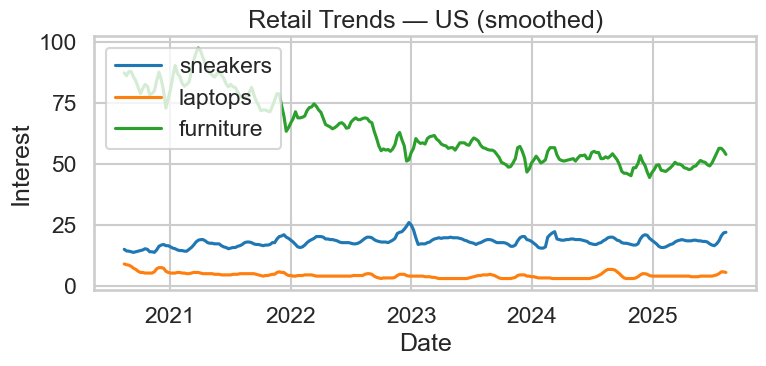

In [9]:
# Export a small preview chart for README
fig, ax = plt.subplots(figsize=(8,4))
for kw in KW_LIST[:3]:
    g = trends.loc[trends["keyword"]==kw]
    ax.plot(g["date"], g["trend_ma"], label=kw)
ax.set_title(f"Retail Trends — {GEO} (smoothed)")
ax.set_xlabel("Date")
ax.set_ylabel("Interest")
ax.legend(loc="upper left")
plt.tight_layout()

png_path = Path("../assets/trends_preview.png")
fig.savefig(png_path, dpi=160)
png_path.as_posix()
